# CNN architectures

In [1]:
import time
import os

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from PIL import Image
import PIL
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms, datasets
torch.set_printoptions(precision=4, linewidth=100)

## Data setup

In [4]:
from glob import glob

In [3]:
%cd data/fish
%cd train
%mkdir ../valid

/home/ec2-user/projects/fast_ai/data/fish
/home/ec2-user/projects/fast_ai/data/fish/train


In [10]:
g = glob('*')
for d in g: os.mkdir('../valid/'+d)

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
# 500ファイルをvalidに移動
for i in range(500): os.rename(shuf[i], '../valid/' + shuf[i])

In [11]:
%mkdir ../sample
%mkdir ../sample/train
%mkdir ../sample/valid

In [13]:
from shutil import copyfile

g = glob('*')
for d in g: 
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [15]:
g = glob('*/*.jpg')
shuf = np.random.permutation(g)
# sampleにファイルをコピー
for i in range(400): copyfile(shuf[i], '../sample/train/' + shuf[i])

%cd ../valid

g = glob('*/*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], '../sample/valid/' + shuf[i])

%cd ..

/home/ec2-user/projects/fast_ai/data/fish/valid
/home/ec2-user/projects/fast_ai/data/fish


In [16]:
%mkdir results
%mkdir sample/results
%cd ../..

/home/ec2-user/projects/fast_ai


### one-hot vector の作成

In [7]:
batch_size = 32
nb_digits = 10
y = torch.LongTensor(batch_size,1).random_() % nb_digits
# One hot encoding buffer that you create out of the loop and just keep reusing
y_onehot = torch.FloatTensor(batch_size, nb_digits)

# In your for loop
y_onehot.zero_()
# scatter_(dim, index, src) dim次元目のindexをsrcの値にする
y_onehot.scatter_(1, y, 1) # y_onehot[i][y[i]] = 1 になる


    1     0     0     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0     0     1     0
    0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     0     1
    0     0     0     0     0     0     1     0     0     0
    0     0     0     0     1     0     0     0     0     0
    0     1     0     0     0     0     0     0     0     0
    1     0     0     0     0     0     0     0     0     0
    0     0     1     0     0     0     0     0     0     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     0     0     0     1     0
    0     0     0     0     0     1     0     0     0     0
    0     0     0     0     0     0     0     1     0     0
    0     0     0     0     0     1     0     0     0     0
    0     1     0     0     0     0    

## Precompute convolutional outputの取得

VGG16をfinetunedして、そのconv layerの出力を以降入力として用いる

In [14]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU (inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU (inplace)
    (4): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU (inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU (inplace)
    (9): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU (inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU (inplace)
    (16): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pa

In [47]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize(224), 
        transforms.CenterCrop(224),
        transforms.ToTensor()
    ]),
}

path = "data/fish/"
batch_size = 12 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x),
                                          data_transforms[x])
                  for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)
use_gpu = torch.cuda.is_available()
print(use_gpu)

{'train': 3277, 'valid': 500} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
True


In [4]:
# 置き換える層以外は再学習しないようにする
for param in vgg16.parameters():
    param.requires_grad = False

In [15]:
num_features = vgg16.classifier[6].in_features
modules = list(vgg16.classifier.children())
modules.pop()
modules.append(torch.nn.Linear(num_features, 8)) # ラベル数は8
new_classifier = torch.nn.Sequential(*modules)
vgg16.classifier = new_classifier

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
if use_gpu:
    vgg16 = vgg16.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier[6].parameters(), lr=0.001, momentum=0.9) # requires_grad=Falseのパラメーターを渡したらエラーが出た
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
model_finetuned = train_model(vgg16, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.1252 Acc: 0.4779
valid Loss: 0.1036 Acc: 0.5680

Epoch 1/9
----------
train Loss: 0.1160 Acc: 0.5093
valid Loss: 0.0999 Acc: 0.5940

Epoch 2/9
----------
train Loss: 0.1156 Acc: 0.4989
valid Loss: 0.0871 Acc: 0.6500

Epoch 3/9
----------
train Loss: 0.1131 Acc: 0.5252
valid Loss: 0.0821 Acc: 0.6640

Epoch 4/9
----------
train Loss: 0.1110 Acc: 0.5273
valid Loss: 0.0801 Acc: 0.6620

Epoch 5/9
----------
train Loss: 0.1144 Acc: 0.5136
valid Loss: 0.0846 Acc: 0.6280

Epoch 6/9
----------
train Loss: 0.1103 Acc: 0.5374
valid Loss: 0.0804 Acc: 0.6840

Epoch 7/9
----------
train Loss: 0.1017 Acc: 0.5658
valid Loss: 0.0702 Acc: 0.7040

Epoch 8/9
----------
train Loss: 0.1001 Acc: 0.5667
valid Loss: 0.0703 Acc: 0.7140

Epoch 9/9
----------
train Loss: 0.1013 Acc: 0.5569
valid Loss: 0.0693 Acc: 0.7260

Training complete in 13m 32s
Best val Acc: 0.726000


In [10]:
torch.save(model_finetuned.state_dict(), "lesson7_finetuned_vgg16.pt")

In [48]:
result_map = {'train': [], 'valid': []}
for phase in ['train', 'valid']:
    model_finetuned.features.train(False)
    for data in dataloaders[phase]:
        inputs, labels = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
        outputs = model_finetuned.features(inputs)
        result_map[phase].append(outputs.data.cpu())

In [49]:
feature_tensors = {x: torch.cat(result_map[x]) for x in ["train", "valid"]}

In [50]:
for x in ["train", "valid"]:
    torch.save(feature_tensors[x], "conv_features_{0}.pt".format(x))

## Precompute convolutional outputのロード

In [168]:
conv_feature_map = {x: torch.load("conv_features_{0}.pt".format(x)).view(-1, 25088) for x in ["train", "valid"]}

In [169]:
print(conv_feature_map["train"].size(), conv_feature_map["valid"].size())

torch.Size([3277, 25088]) torch.Size([500, 25088])


## Muti-input

In [26]:
path = "data/fish/"

In [37]:
filenames = glob(path+"train/*/*")
raw_val_sizes = [PIL.Image.open(f).size for f in glob(path+"valid/*/*")]

In [32]:
filenames[0]

'data/fish/train/DOL/img_03259.jpg'

In [33]:
sizes = [PIL.Image.open(f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}

In [34]:
import collections
collections.Counter(sizes)

Counter({(1192, 670): 170,
         (1244, 700): 25,
         (1276, 718): 191,
         (1280, 720): 1885,
         (1280, 750): 518,
         (1280, 924): 53,
         (1280, 974): 336,
         (1334, 750): 30,
         (1518, 854): 38,
         (1732, 974): 31})

In [175]:
p=0.6

In [183]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(25088, 512)
        self.fc2 = nn.Linear(512, 512)
        self.bn0 = nn.BatchNorm1d(10)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(522, 8)

    def forward(self, x, y):
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.bn2(x)
        x = self.fc3(torch.cat((x,self.bn0(y)), dim=1))
        return x

In [184]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


In [185]:
model = Net()
if use_gpu:
    model = model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [186]:
from torch.utils.data import Dataset, DataLoader

class LinearDataset(Dataset):
    def __init__(self, image_folder, features, num_labels):
        self.image_folder = image_folder
        self.features = features
        self.y_onehot = torch.FloatTensor(1, num_labels)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        image, label = self.image_folder.__getitem__(idx)
        self.y_onehot.zero_()
        # scatter_(dim, index, src) dim次元目のindexをsrcの値にする
        # y_onehot[i][y[i]] = 1 になる
        size_onehot = self.y_onehot.scatter_(1, torch.LongTensor([size2id[image.size]]).unsqueeze(1), 1.0)
        return self.features[idx], label, size_onehot.squeeze(dim=0)

In [190]:
path = "data/fish/"
batch_size = 32 # バッチサイズが大きいとGPUのメモリに乗らないので注意
image_datasets = {x: datasets.ImageFolder(os.path.join(path, x))
                  for x in ['train', 'valid']}
linear_datasets = {x: LinearDataset(image_datasets[x], conv_feature_map[x], len(id2size)) for x in ['train', 'valid']}
dataloaders = {x: torch.utils.data.DataLoader(linear_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'valid']}
dataset_sizes = {x: len(linear_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes
print(dataset_sizes, class_names)

{'valid': 500, 'train': 3277} ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']


In [191]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels, sizes = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                    sizes = Variable(sizes.cuda())
                else:
                    inputs, labels, sizes = Variable(inputs), Variable(labels), Variable(sizes)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs, sizes)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] # loss.dataはsize 1 のTensorなので[0]を取る
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # 最も良いモデルの重みを変数に保持
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [192]:
model_trained = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.0519 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 1/9
----------
train Loss: 0.0518 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 2/9
----------
train Loss: 0.0517 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 3/9
----------
train Loss: 0.0517 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 4/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 5/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 6/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 7/9
----------
train Loss: 0.0514 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 8/9
----------
train Loss: 0.0515 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Epoch 9/9
----------
train Loss: 0.0514 Acc: 0.4571
valid Loss: nan Acc: 0.0580

Training complete in 3m 59s
Best val Acc: 0.058000


## Bounding boxes & multi output

In [18]:
import ujson as json

In [5]:
path = "data/fish/"

In [132]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [141]:
def make_list(data_kind):
    raw_filenames_list = [[fpath.rsplit("/", 1)[-1] for fpath in glob(path+"{0}/{1}/*".format(data_kind, anno_class.upper()))] 
                          for anno_class in anno_classes]
    raw_filenames = []
    for i in range(0, len(anno_classes)):
        raw_filenames.extend(sorted(raw_filenames_list[i]))
    return raw_filenames

In [168]:
raw_filenames = make_list('train')
raw_val_filenames = make_list('valid')
# raw_filenames = [fpath.rsplit("/", 1)[-1] for fpath in glob(path+"train/*/*")]
# raw_val_filenames = [fpath.rsplit("/", 1)[-1] for fpath in glob(path+"valid/*/*")]

In [169]:
raw_filenames[0]

'img_00003.jpg'

In [170]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [171]:
import os
import requests

def save_data(filename, data):
    with open(filename, "wb") as fout:
        fout.write(data)

def get_annotations():
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
        url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'    
        for url_suffix, md5_hash in annot_urls.items():
            fname = url_suffix.rsplit('/', 1)[-1]
            response = requests.get(url_prefix + url_suffix)
            save_data(os.path.abspath(os.path.join(cache_subdir, fname)), response.content)
        
        

In [172]:
get_annotations()

In [173]:
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(path, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

In [174]:
bb_json['img_04908.jpg']

{'class': 'rect',
 'height': 246.75000000000074,
 'width': 432.8700000000013,
 'x': 465.3000000000014,
 'y': 496.32000000000147}

In [175]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [176]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [177]:
for f in raw_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys(): bb_json[f] = empty_bbox

In [178]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [179]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

In [180]:
from matplotlib import pyplot as plt
def to_plot(img):
    return img.numpy().transpose((1, 2, 0))

def plot(img):
    plt.imshow(to_plot(img))

In [226]:
raw_val_filenames[1]

'img_00015.jpg'

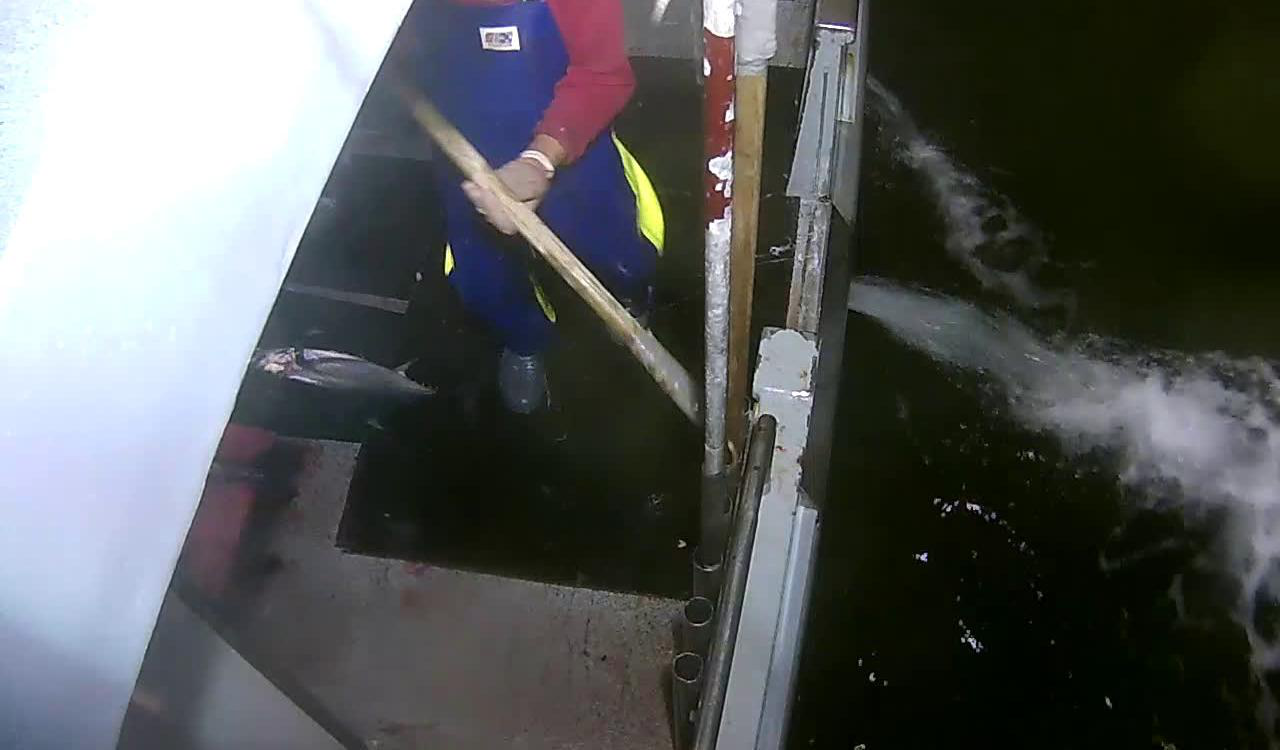

In [227]:
datasets.ImageFolder(os.path.join(path, 'valid'))[1][0]

In [213]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor()
    ]),
}
raw_image_datasets = {x: datasets.ImageFolder(os.path.join(path, x), data_transforms['train']) for x in ['train', 'valid']}

In [214]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3)

def show_bb(i):
    bb = val_bbox[i]
    plot(raw_image_datasets['valid'][i][0])
    plt.gca().add_patch(create_rect(bb))

In [215]:
%matplotlib inline

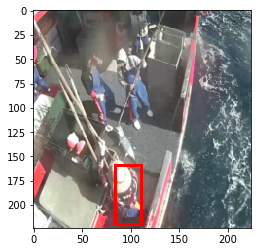

In [229]:
show_bb(0)

### Create & train model

In [ ]:
p=0.6

In [ ]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb_pred, 'yellow'))
    ax.add_patch(create_rect(bb))

## Larger size

### Set up data

In [ ]:
trn = get_data(path+'train', (360,640))
val = get_data(path+'valid', (360,640))

In [ ]:
plot(trn[0])

### Fully convolutional net (FCN)